# BiLSTM_np20ng_30K

Here, we train a Bidirectional Long Short Term Memory (BiLSTM) network on Nepali newsgroup dataset with 20 classes and 30K total samples.

This notebook was run on Google Colab Environment with Tesla T4 GPU.

The experiment was tracked using Weights and Biases (Wandb)

In [1]:
!nvidia-smi

Sat Oct 22 11:57:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/ait_research_experiments')

### Load Train Valid and Test Data
**Note:** The dataset is already preprocessed and stopwords have been removed.

* np16ng with 30K datasize

In [4]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 166 kB 89.5 MB/s 
     |████████████████████████████████| 182 kB 87.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 166 kB 94.1 MB/s 
     |████████████████████████████████| 162 kB 98.2 MB/s 
     |████████████████████████████████| 162 kB 75.0 MB/s 
     |████████████████████████████████| 158 kB 93.8 MB/s 
     |████████████████████████████████| 157 kB 79.6 MB/s 
     |████████████████████████████████| 157 kB 102.1 MB/s 
     |████████████████████████████████| 157 kB 81.0 MB/s 
     |████████████████████████████████| 157 kB 102.4 MB/s 
     |████████████████████████████████| 157 kB 79.2 MB/s 
     |████████████████████████████████| 157 kB 88.9 MB/s 
     |████████████████████████████████| 157 kB 103.9 MB/s 
     |█████████████████████████

In [5]:
import time
import pandas as pd
import numpy as np
from tensorflow import keras
from tqdm import tqdm
import wandb
from wandb.keras import WandbCallback

In [6]:
wandb_config = {}

In [7]:
# import wandb

# # Login if not logged in
# !wandb login 93f20611e40141f3db8be493fb3ee822860f2493

# # Initialize API
# api = wandb.Api()

# # Get the Run name (entity/project/id)
# run = api.run('suyogyart/ait_research_experiments/23fv9ful')

# # Add additional keys and values
# run.config["test_precision_weighted"] = 0.79

# # Persist / Update the Run
# run.update()

In [8]:
size = '30K'
dataset = 'np20ng'
t_id = 'T5'
dataset_path =  os.path.join(os.getcwd(), 'dataset', dataset)
fasttext_path = os.path.join(os.getcwd(), 'fasttext/cc.ne.300.bin')
model_arch = 'BiLSTM'
model_path = os.path.join(os.getcwd(), 'models')
model_checkpoint_path = os.path.join(os.getcwd(), 'models/rnn_ckpt', 'BiLSTM_np20ng_30K_T5_{epoch:02d}-{val_accuracy:.4f}.hdf5')

In [9]:
train_path = os.path.join(dataset_path, f'{dataset}_train_nosw.csv')
valid_path = os.path.join(dataset_path, f'{dataset}_valid_nosw.csv')
test_path = os.path.join(dataset_path, f'{dataset}_test_nosw.csv')
wandb_config['remove_stopwords'] = True

# train_path = os.path.join(dataset_path, f'{dataset}_{size}_train.csv')
# valid_path = os.path.join(dataset_path, f'{dataset}_{size}_valid.csv')
# test_path = os.path.join(dataset_path, f'{dataset}_{size}_test.csv')
# wandb_config['remove_stopwords'] = False

In [10]:
train_df = pd.read_csv(train_path)[['content', 'category', 'labels']]
valid_df = pd.read_csv(valid_path)[['content', 'category', 'labels']]
test_df = pd.read_csv(test_path)[['content', 'category', 'labels']]

print(train_df.shape, valid_df.shape, test_df.shape)

(24000, 3) (3000, 3) (3000, 3)


In [11]:
wandb_config['model_arch'] = model_arch
wandb_config['size'] = '30K'
wandb_config['dataset_id'] = dataset
wandb_config['data_size'] = 30000
wandb_config['num_classes'] = train_df.category.nunique()

In [12]:
wandb_config

{'remove_stopwords': True,
 'model_arch': 'BiLSTM',
 'size': '30K',
 'dataset_id': 'np20ng',
 'data_size': 30000,
 'num_classes': 20}

### Bi-LSTM

In [13]:
from keras import layers
from keras import losses
from keras import preprocessing
from keras import utils
from keras.layers.preprocessing.text_vectorization import TextVectorization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from keras.optimizers import Adam

In [14]:
MAX_FEATURES = 300000
MAX_SEQ_LEN = 512

tokenizer = Tokenizer(num_words = MAX_FEATURES, lower=False)
tokenizer.fit_on_texts(train_df['content'].values)
X_train = tokenizer.texts_to_sequences(train_df['content'].values)
X_train = pad_sequences(X_train, padding = 'post', maxlen=MAX_SEQ_LEN)
y_train = pd.get_dummies(train_df['category']).values

X_valid = tokenizer.texts_to_sequences(valid_df['content'].values)
X_valid = pad_sequences(X_valid, padding = 'post', maxlen=MAX_SEQ_LEN)
y_valid = pd.get_dummies(valid_df['category']).values

vocab_size = len(tokenizer.word_index)+1
print('Vocab Size: ', vocab_size)

Vocab Size:  213462


In [15]:
wandb_config['max_features'] = MAX_FEATURES
wandb_config['max_seq_len'] = MAX_SEQ_LEN
wandb_config['vocab_size'] = vocab_size

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.grid()
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.grid()
    plt.show()

### Load FastText model for Nepali and get FastText embeddings


In [17]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.6 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3161990 sha256=e274c96f517f2461d61adead17258b5fcdd750d5352478d978aeff32d88971ce
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [18]:
import fasttext

ft = fasttext.load_model(fasttext_path)
wandb_config['embeddings'] = 'FastText'

In [19]:
print('Getting all words from the embeddings...')
all_words = ft.get_words()
print('Total words: ', len(all_words))

print('Creating embeddings vector...')
embeddings_vector = {}
for word in tqdm(all_words):
    embeddings_vector[word] = ft.get_word_vector(word)

print('Total Vectors: ', len(embeddings_vector))

Getting all words from the embeddings...
Total words:  584436
Creating embeddings vector...


100%|██████████| 584436/584436 [00:08<00:00, 70052.91it/s]

Total Vectors:  584436


In [20]:
print('Creating embedding matrix...')
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(tokenizer.word_index.items()):
    embedding_value = embeddings_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

print('Embedding Matrix shape: ', embedding_matrix.shape)

Creating embedding matrix...


100%|██████████| 213461/213461 [00:00<00:00, 625528.59it/s]

Embedding Matrix shape:  (213462, 300)


### Model Setup

In [21]:
EMBED_DIM = 300
ES_PATIENCE = 5
ES_CALLBACK = EarlyStopping(patience=ES_PATIENCE, verbose=1)
MODEL_CHECKPOINT_CALLBACK = ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True, 
    verbose=1
)

EPOCH = 50
LEARNING_RATE = 0.001
BATCH_SIZE = 64

wandb_config['embedding_dim'] = EMBED_DIM
wandb_config['total_epochs'] = EPOCH
wandb_config['learning_rate'] = LEARNING_RATE
wandb_config['train_batch_size'] = BATCH_SIZE

In [25]:
# def create_model():
#     model = keras.Sequential()
#     model.add(Embedding(vocab_size, EMBED_DIM, input_length=X_train.shape[1], weights=[embedding_matrix], trainable = False))
#     model.add(Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)))
#     model.add(Dropout(0.5))
#     model.add(Bidirectional(LSTM(128, dropout=0.2)))
#     model.add(Dense(100, activation = 'relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(50, activation = 'relu'))
#     model.add(Dense(16, activation = 'softmax'))

#     model.summary()

#     model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics = ['accuracy'])

#     return model

def create_model():
    model = keras.Sequential()
    model.add(Embedding(vocab_size, EMBED_DIM, input_length=X_train.shape[1], weights=[embedding_matrix], trainable = False))
    model.add(Bidirectional(LSTM(256, dropout=0.2, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(256, dropout=0.2)))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(train_df.category.nunique(), activation = 'softmax'))

    model.summary()

    model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics = ['accuracy'])

    return model

In [26]:
model = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 300)          64038600  
                                                                 
 bidirectional_2 (Bidirectio  (None, 512, 512)         1140736   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 512, 512)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)              

### WandB initialization and config update

In [27]:
PROJECT_ID = 'ait_research_experiments'
TRAINING_ID = f'{model_arch}_{dataset}_{size}_{t_id}'
TAGS = [model_arch, dataset, str(wandb_config['data_size'])]

In [28]:
# Login to WandB
!wandb login 93f20611e40141f3db8be493fb3ee822860f2493

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [29]:
wandb.init(project=PROJECT_ID, 
           name=TRAINING_ID,
           tags=TAGS,
           notes='BL256, BL256, D128, D64',
           config=wandb_config)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: suyogyart. Use `wandb login --relogin` to force relogin


In [30]:
history = model.fit(X_train, 
                    y_train, 
                    epochs = EPOCH, 
                    batch_size=BATCH_SIZE, 
                    verbose = 1, 
                    validation_data = (X_valid, y_valid), 
                    callbacks=[ES_CALLBACK, MODEL_CHECKPOINT_CALLBACK, WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
375/375 [==============================] - ETA: 0s - loss: 1.8779 - accuracy: 0.4005
Epoch 1: val_loss improved from inf to 1.32488, saving model to /content/drive/MyDrive/ait_research_experiments/models/rnn_ckpt/BiLSTM_np20ng_30K_T5_01-0.5773.hdf5


wandb: Adding directory to artifact (/content/drive/MyDrive/ait_research_experiments/wandb/run-20221022_120025-2yhlmzp4/files/model-best)... Done. 2.1s


375/375 [==============================] - 136s 337ms/step - loss: 1.8779 - accuracy: 0.4005 - val_loss: 1.3249 - val_accuracy: 0.5773
Epoch 2/50
375/375 [==============================] - ETA: 0s - loss: 1.3264 - accuracy: 0.5929
Epoch 2: val_loss improved from 1.32488 to 1.08417, saving model to /content/drive/MyDrive/ait_research_experiments/models/rnn_ckpt/BiLSTM_np20ng_30K_T5_02-0.6780.hdf5


wandb: Adding directory to artifact (/content/drive/MyDrive/ait_research_experiments/wandb/run-20221022_120025-2yhlmzp4/files/model-best)... Done. 2.1s


375/375 [==============================] - 128s 341ms/step - loss: 1.3264 - accuracy: 0.5929 - val_loss: 1.0842 - val_accuracy: 0.6780
Epoch 3/50
375/375 [==============================] - ETA: 0s - loss: 1.1366 - accuracy: 0.6595
Epoch 3: val_loss improved from 1.08417 to 1.04296, saving model to /content/drive/MyDrive/ait_research_experiments/models/rnn_ckpt/BiLSTM_np20ng_30K_T5_03-0.6837.hdf5


wandb: Adding directory to artifact (/content/drive/MyDrive/ait_research_experiments/wandb/run-20221022_120025-2yhlmzp4/files/model-best)... Done. 2.0s


375/375 [==============================] - 128s 341ms/step - loss: 1.1366 - accuracy: 0.6595 - val_loss: 1.0430 - val_accuracy: 0.6837
Epoch 4/50
375/375 [==============================] - ETA: 0s - loss: 1.0127 - accuracy: 0.7021
Epoch 4: val_loss improved from 1.04296 to 0.89450, saving model to /content/drive/MyDrive/ait_research_experiments/models/rnn_ckpt/BiLSTM_np20ng_30K_T5_04-0.7340.hdf5


wandb: Adding directory to artifact (/content/drive/MyDrive/ait_research_experiments/wandb/run-20221022_120025-2yhlmzp4/files/model-best)... Done. 2.1s


375/375 [==============================] - 127s 339ms/step - loss: 1.0127 - accuracy: 0.7021 - val_loss: 0.8945 - val_accuracy: 0.7340
Epoch 5/50
375/375 [==============================] - ETA: 0s - loss: 0.9220 - accuracy: 0.7265
Epoch 5: val_loss did not improve from 0.89450
375/375 [==============================] - 98s 261ms/step - loss: 0.9220 - accuracy: 0.7265 - val_loss: 0.9019 - val_accuracy: 0.7303
Epoch 6/50
375/375 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.7493
Epoch 6: val_loss improved from 0.89450 to 0.78565, saving model to /content/drive/MyDrive/ait_research_experiments/models/rnn_ckpt/BiLSTM_np20ng_30K_T5_06-0.7680.hdf5


wandb: Adding directory to artifact (/content/drive/MyDrive/ait_research_experiments/wandb/run-20221022_120025-2yhlmzp4/files/model-best)... Done. 2.0s


375/375 [==============================] - 127s 338ms/step - loss: 0.8523 - accuracy: 0.7493 - val_loss: 0.7857 - val_accuracy: 0.7680
Epoch 7/50
375/375 [==============================] - ETA: 0s - loss: 0.7942 - accuracy: 0.7674
Epoch 7: val_loss improved from 0.78565 to 0.77701, saving model to /content/drive/MyDrive/ait_research_experiments/models/rnn_ckpt/BiLSTM_np20ng_30K_T5_07-0.7673.hdf5


wandb: Adding directory to artifact (/content/drive/MyDrive/ait_research_experiments/wandb/run-20221022_120025-2yhlmzp4/files/model-best)... Done. 2.0s


375/375 [==============================] - 127s 337ms/step - loss: 0.7942 - accuracy: 0.7674 - val_loss: 0.7770 - val_accuracy: 0.7673
Epoch 8/50
375/375 [==============================] - ETA: 0s - loss: 0.8216 - accuracy: 0.7588
Epoch 8: val_loss did not improve from 0.77701
375/375 [==============================] - 98s 261ms/step - loss: 0.8216 - accuracy: 0.7588 - val_loss: 0.7988 - val_accuracy: 0.7577
Epoch 9/50
375/375 [==============================] - ETA: 0s - loss: 0.7683 - accuracy: 0.7693
Epoch 9: val_loss improved from 0.77701 to 0.74650, saving model to /content/drive/MyDrive/ait_research_experiments/models/rnn_ckpt/BiLSTM_np20ng_30K_T5_09-0.7717.hdf5


wandb: Adding directory to artifact (/content/drive/MyDrive/ait_research_experiments/wandb/run-20221022_120025-2yhlmzp4/files/model-best)... Done. 2.0s


375/375 [==============================] - 128s 341ms/step - loss: 0.7683 - accuracy: 0.7693 - val_loss: 0.7465 - val_accuracy: 0.7717
Epoch 10/50
375/375 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.7922
Epoch 10: val_loss improved from 0.74650 to 0.70244, saving model to /content/drive/MyDrive/ait_research_experiments/models/rnn_ckpt/BiLSTM_np20ng_30K_T5_10-0.7867.hdf5


wandb: Adding directory to artifact (/content/drive/MyDrive/ait_research_experiments/wandb/run-20221022_120025-2yhlmzp4/files/model-best)... Done. 2.0s


375/375 [==============================] - 127s 340ms/step - loss: 0.6926 - accuracy: 0.7922 - val_loss: 0.7024 - val_accuracy: 0.7867
Epoch 11/50
375/375 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.7996
Epoch 11: val_loss did not improve from 0.70244
375/375 [==============================] - 98s 262ms/step - loss: 0.6617 - accuracy: 0.7996 - val_loss: 0.7463 - val_accuracy: 0.7790
Epoch 12/50
375/375 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.8011
Epoch 12: val_loss improved from 0.70244 to 0.66691, saving model to /content/drive/MyDrive/ait_research_experiments/models/rnn_ckpt/BiLSTM_np20ng_30K_T5_12-0.7973.hdf5


wandb: Adding directory to artifact (/content/drive/MyDrive/ait_research_experiments/wandb/run-20221022_120025-2yhlmzp4/files/model-best)... Done. 2.0s


375/375 [==============================] - 128s 341ms/step - loss: 0.6747 - accuracy: 0.8011 - val_loss: 0.6669 - val_accuracy: 0.7973
Epoch 13/50
375/375 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.8071
Epoch 13: val_loss improved from 0.66691 to 0.64581, saving model to /content/drive/MyDrive/ait_research_experiments/models/rnn_ckpt/BiLSTM_np20ng_30K_T5_13-0.8103.hdf5


wandb: Adding directory to artifact (/content/drive/MyDrive/ait_research_experiments/wandb/run-20221022_120025-2yhlmzp4/files/model-best)... Done. 2.0s


375/375 [==============================] - 128s 340ms/step - loss: 0.6323 - accuracy: 0.8071 - val_loss: 0.6458 - val_accuracy: 0.8103
Epoch 14/50
375/375 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.8242
Epoch 14: val_loss improved from 0.64581 to 0.61547, saving model to /content/drive/MyDrive/ait_research_experiments/models/rnn_ckpt/BiLSTM_np20ng_30K_T5_14-0.8107.hdf5


wandb: Adding directory to artifact (/content/drive/MyDrive/ait_research_experiments/wandb/run-20221022_120025-2yhlmzp4/files/model-best)... Done. 2.0s


375/375 [==============================] - 128s 342ms/step - loss: 0.5795 - accuracy: 0.8242 - val_loss: 0.6155 - val_accuracy: 0.8107
Epoch 15/50
375/375 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.8297
Epoch 15: val_loss did not improve from 0.61547
375/375 [==============================] - 98s 262ms/step - loss: 0.5521 - accuracy: 0.8297 - val_loss: 0.6200 - val_accuracy: 0.8173
Epoch 16/50
375/375 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.8368
Epoch 16: val_loss did not improve from 0.61547
375/375 [==============================] - 98s 261ms/step - loss: 0.5256 - accuracy: 0.8368 - val_loss: 0.6257 - val_accuracy: 0.8093
Epoch 17/50
375/375 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.8430
Epoch 17: val_loss did not improve from 0.61547
375/375 [==============================] - 98s 261ms/step - loss: 0.4996 - accuracy: 0.8430 - val_loss: 0.6424 - val_accuracy: 0.8130
Epoch 18/50
375/375 [=======

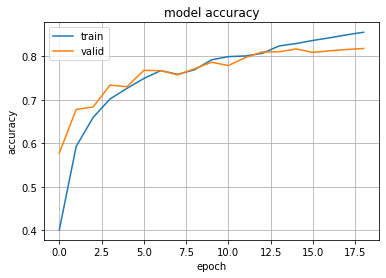

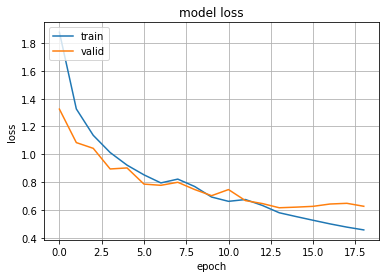

In [31]:
plot_history(history)

Best Epoch: 13

### Test Set Evaluation

In [32]:
artifact = wandb.run.use_artifact(f'suyogyart/ait_research_experiments/model-{model_arch}_{dataset}_{size}_{t_id}:latest')

datadir = artifact.download()

wandb: Downloading large artifact model-BiLSTM_np20ng_30K_T5:latest, 280.76MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.8


In [33]:
# Create model
model = create_model()

# Load weights
model.load_weights(datadir)
# model.load_weights('/content/drive/MyDrive/ait_research_experiments/models/rnn_ckpt/BiLSTM_np16ng_30K_T2_PCD_10-0.81.hdf5')

print("Created model and loaded weights from file")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 300)          64038600  
                                                                 
 bidirectional_4 (Bidirectio  (None, 512, 512)         1140736   
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 512, 512)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [34]:
from sklearn.metrics import classification_report, accuracy_score, precision_score

X_test = tokenizer.texts_to_sequences(test_df['content'].values)
X_test = pad_sequences(X_test, padding = 'post', maxlen=512)

predictions = model.predict(X_test)

y_pred=np.argmax(predictions, axis=1)

y_test = test_df['labels']

print(classification_report(y_test, y_pred, target_names=np.sort(train_df.category.unique())))

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = round(precision_score(y_test, y_pred, average='weighted'), 4)

print('Test Accuracy:', test_accuracy)
print('Test Precision weighted:', test_precision)

94/94 [==============================] - 6s 54ms/step
               precision    recall  f1-score   support

         Arts       0.78      0.77      0.78       150
   Automobile       0.83      0.93      0.88       150
         Bank       0.82      0.84      0.83       150
     Business       0.62      0.57      0.59       150
        Crime       0.91      0.90      0.90       150
      Economy       0.65      0.55      0.59       150
    Education       0.85      0.94      0.89       150
   Employment       0.77      0.88      0.82       150
Entertainment       0.92      0.71      0.80       150
       Health       0.80      0.79      0.80       150
    Lifestyle       0.81      0.92      0.86       150
   Literature       0.77      0.89      0.82       150
       Market       0.83      0.82      0.83       150
      Opinion       0.93      0.83      0.87       150
     Politics       0.90      0.83      0.87       150
      Society       0.80      0.74      0.77       150
       Spo

In [35]:
wandb.log({'test_accuracy': test_accuracy})
wandb.log({'test_precision_weighted': test_precision})

In [36]:
# Log Confusion Matrix from wandb
wandb.sklearn.plot_confusion_matrix(
    y_true=y_test, 
    y_pred=y_pred, 
    labels=np.sort(train_df.category.unique())
)

In [37]:
# Log Classification Report as a table
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, target_names=np.sort(train_df.category.unique()), output_dict=True)
df = pd.DataFrame(report).transpose()
df = df.drop('accuracy')
df = df.reset_index(drop=True)
df = df.round(3)
df.support = df.support.astype('int')

wandb.log({'classification_report': df})

In [38]:
wandb.finish()

accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇██████
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
test_accuracy,▁
test_precision_weighted,▁
val_accuracy,▁▄▄▆▅▇▇▆▇▇▇▇███████
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁
accuracy,0.85575
best_epoch,13
best_val_loss,0.61547
epoch,18


### Save Model

In [39]:
model.save(os.path.join(os.getcwd(), f'models/{model_arch}_{dataset}_{size}_{t_id}_{test_accuracy}.h5'))